In [4]:
from IPython.display import Image

import pandas as pd
import numpy as np
from pprint import pprint



import os, sys
file_dir = '/Users/imsoyoung/Soyoung/Ajou/Project/DigitalPhenotype/DigitalPhenotype_overall/Code/Util'
sys.path.append(os.path.dirname(os.path.abspath
                                (os.path.abspath(file_dir))))

import Util.Utility as util


%matplotlib inline
import matplotlib.pylab as plt
import datetime 
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

# !pip install networkx
import networkx as nx


***IDEA from KDD paper***

- Action Graph :  a weighted, directed graph for capturing individual user’s in-app action transition patterns


- 사용자의 ***앱 사용***을 Action Graph 로 표현할 수 있다면?


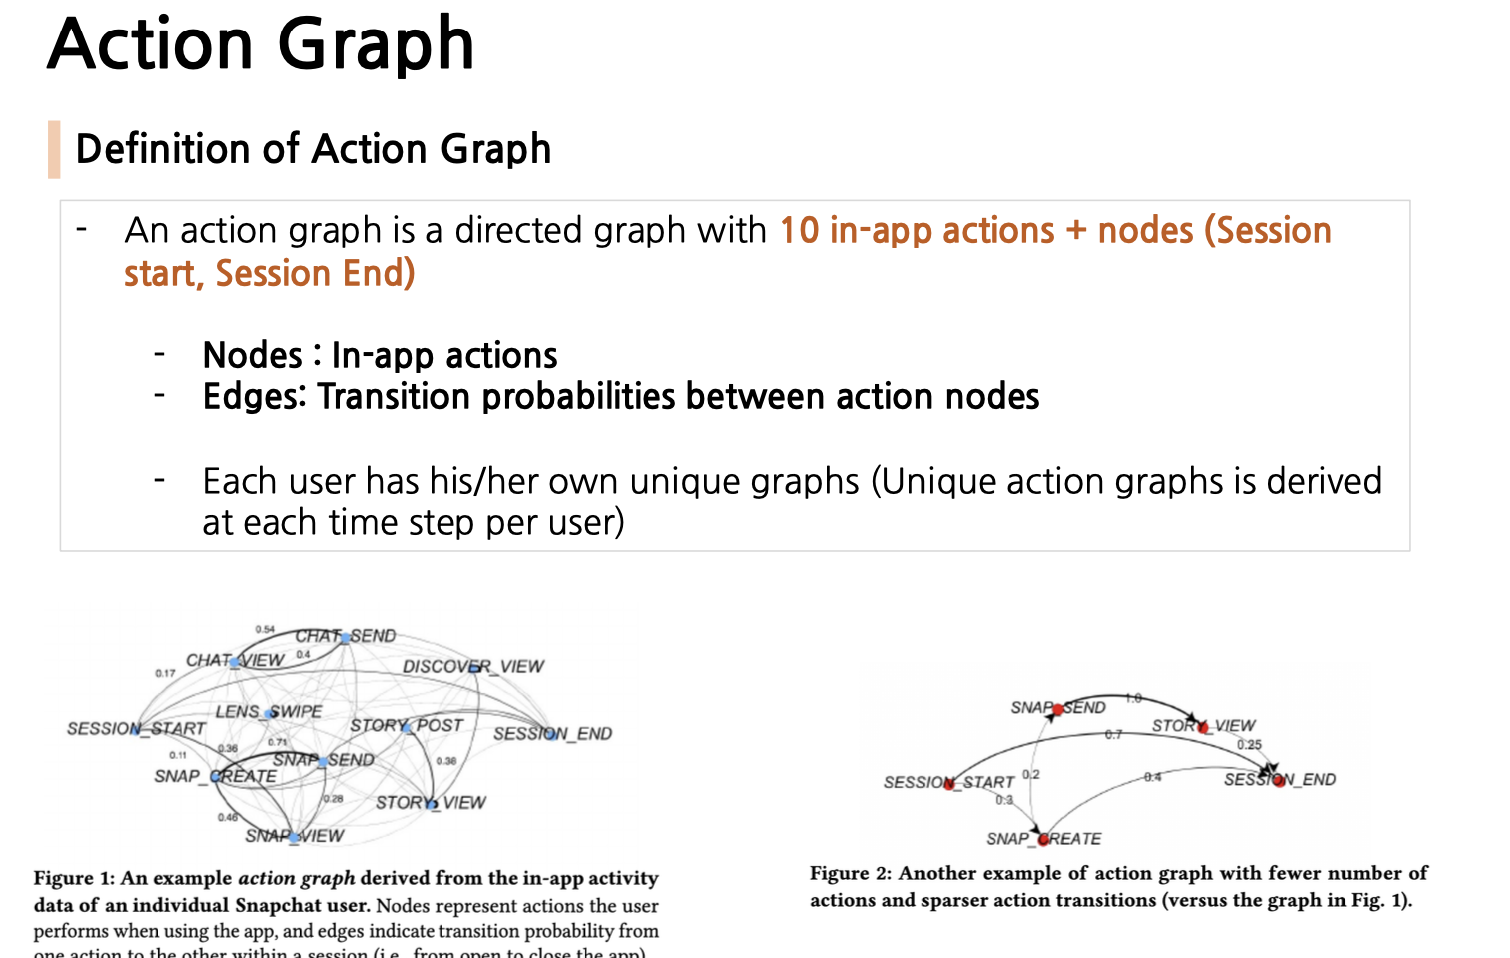

In [19]:
Image("../../img/DP_ActionGraph.png") 

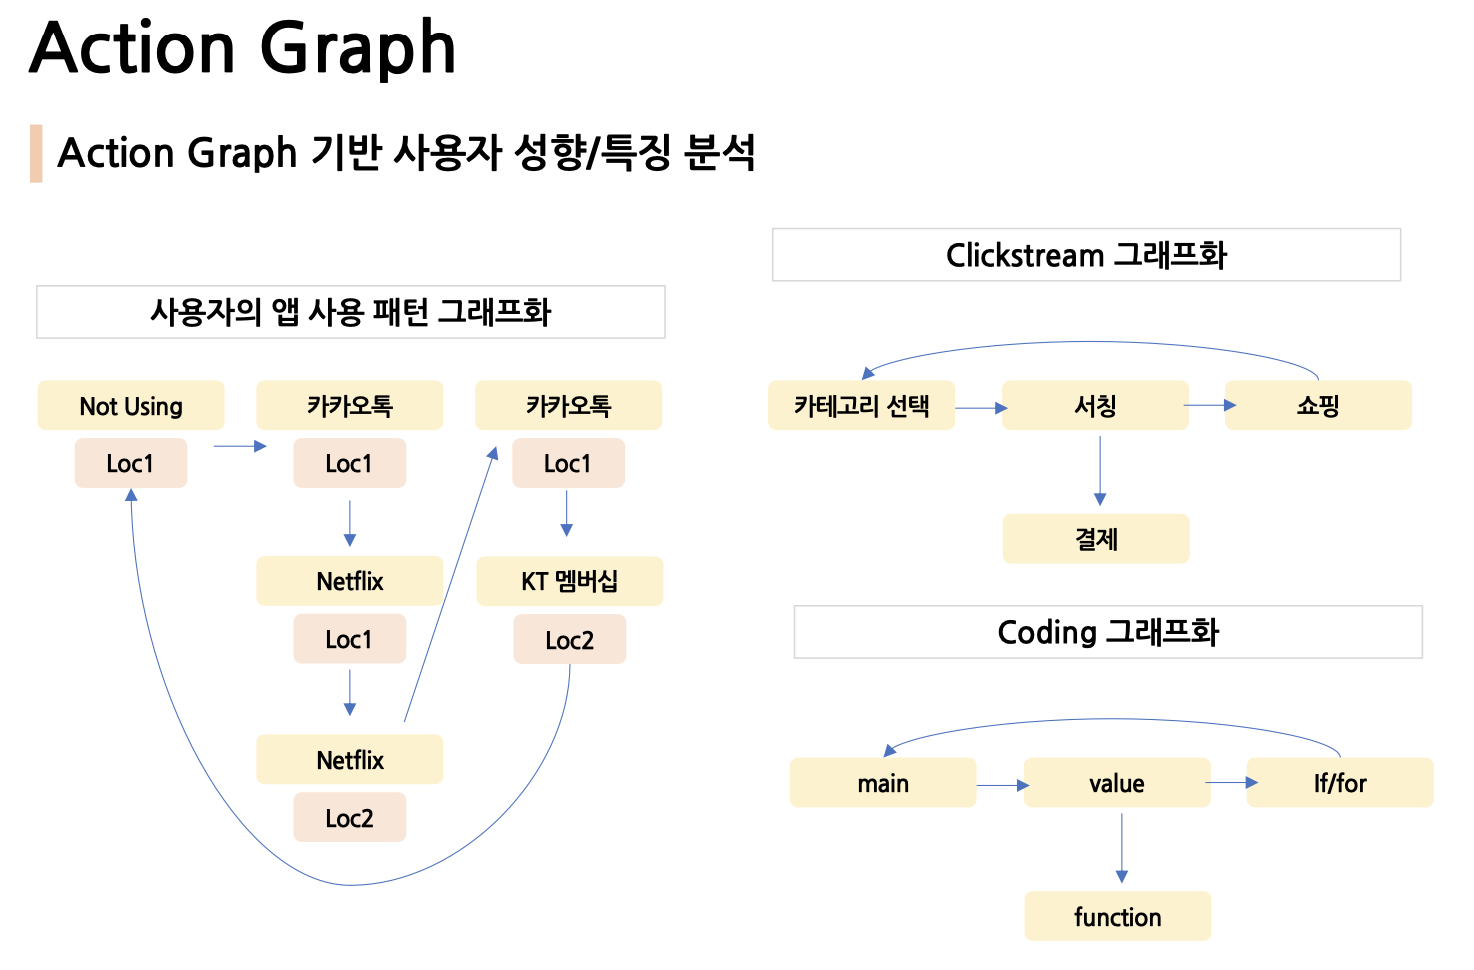

In [16]:
Image("../../img/DP_ActionGraph_adopt.png") 

In [6]:
app = pd.read_csv('../01.Preprocess/result/A_categorized.csv')
util.toDatetime(app, ['date'], '%Y%m%d')
app.head(3)

,Unnamed: 0,_id,uid,date,stime,etime,packageName,total,isInUsable,packageFullName,category
0,2,3,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:11:59,2018-12-03 00:12:10,캐시워크,11,True,com.cashwalk.cashwalk,Health & Fitness
1,17,20,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:21,2018-12-03 00:13:24,카카오톡,3,True,com.kakao.talk,Communication
2,19,22,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:32,2018-12-03 00:13:33,카카오톡,1,True,com.kakao.talk,Communication


# App Category 전처리

- LDA 분석시, Communication 의 비율이 너무 큼
    - Communication --> Chatting / SNS 분리
    
    
- Background, Health & Fitness 제거
    - Background 에서 작동하는 앱 제거
  

In [34]:
app['category'] = app.apply(lambda row : 'Chat' if row['packageName'] == '카카오톡' else row['category'], axis=1)

count = app.groupby('category')['total'].count().reset_index()
count.sort_values(by='total', ascending=False)


,category,total
10,Health & Fitness,1602
3,Chat,1584
5,Communication,1020
0,Background,432
9,Food & Drink,145
4,Comics,139
12,Music,124
6,Education,104
13,Photography,104
7,Entertainment,76


In [28]:
print(set(app[app['category']=='Communication']['packageName']))

app[app['category']=='Communication'].groupby('packageName')['total'].count()

{'Chrome', 'Gmail', '에브리타임', '아주톡톡', 'Facebook', 'Messenger', 'NAVER', 'Instagram', 'Between', 'BAND'}


packageName
BAND           8
Between        1
Chrome        54
Facebook     572
Gmail         33
Instagram     13
Messenger      5
NAVER        171
아주톡톡           1
에브리타임        162
Name: total, dtype: int64

In [30]:
app_sub = app[~app['category'].isin(['Health & Fitness', 'Background'])]

# Count Transition

In [11]:
app_sub['next_category'] = app_sub['category'].shift(-1)
app_sub['transition'] = app_sub.apply(lambda row: True if row['category']!= row['next_category'] else False, axis=1)

/Users/imsoyoung/opt/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/imsoyoung/opt/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
def getTransOfCat(df, current_cat):
    cat_counts = {}
    
    for cat in cat_list:
        if cat != current_cat:
            cat_counts[cat] = 0
            df_cat = df[df['next_category'] == cat]['category'].count()
            cat_counts[cat] += df_cat
        
    return cat_counts

    
cat_list = list(set(app_sub['category']))

trans_df = pd.DataFrame(index = cat_list, columns = cat_list )
trans_df = trans_df.fillna(0)

trans_dict = {}

for cat in cat_list:
    for day in list(set(app_sub['date'])):
        tmp_df = pd.DataFrame(index = cat_list, columns = cat_list )

        tmp = app_sub[app_sub['date']==day]
        trans = tmp[(tmp['category']==cat) & (tmp['transition']==True)]

        cat_counts = getTransOfCat(trans, cat)

#         print(cat_counts)

        for key, value in cat_counts.items():
#             print(cat, key, value[0])
            tmp_df.loc[(cat), (key)] = value
    
        trans_df = pd.concat([trans_df, tmp_df])

In [13]:
trans_df = trans_df.head()
print(trans_df.shape)
trans_df.head()

(5, 15)


,Music,Photography,Chat,Productivity,Food & Drink,Business,Shopping,Travel & Local,Finance,Comics,Entertainment,Communication,Lifestyle,Education,Books & Reference
Music,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Photography,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Productivity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Food & Drink,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
trans_array = trans_df.to_numpy()



G = nx.from_numpy_matrix(trans_array, nodelist = cat_list)
nx.draw(G, with_labels=True)


G = nx.from_numpy_matrix(alignments)
G = nx.maximum_spanning_tree(G)

pos = {}
for i in range(len(G.nodes)):
    pos[i] = np.array([time[i], y[i]])

mst_edges = set(nx.maximum_spanning_tree(G).edges())

weights = [ G[u][v]['weight'] if (not (u, v) in mst_edges) else 8
            for u, v in G.edges() ]

plt.figure()
nx.draw(G, pos, edges=G.edges(), width=10)
plt.ylim([-1, 1])
plt.savefig(namespace + '.svg') 

TypeError: from_numpy_matrix() got an unexpected keyword argument 'nodelist'